In [1]:
import numpy as np
from keras.layers import Conv2D, Activation # for the convnet structure
from keras.models import Sequential # for the overall definition
from keras import backend as K # for the custom sparse loss

from keras import losses # for the KL divergence

import librosa                          # audio signal processing, feature extraction
from librosa import display             # plot the spectrogram
import matplotlib.pyplot as plt         # general plotting

Using TensorFlow backend.


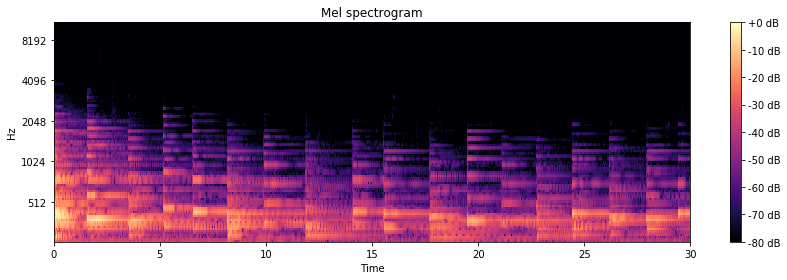

S dimensions: (128, 2584)
S type: float32


In [4]:
# get a spectrogram
def compute_spectrogram(audiofile, no_mels, fft_size, hop_size):
    [y, sr] = librosa.core.load(audiofile, sr=None, mono=True)
    
    # downsampling?
    #y = librosa.resample(y=y,orig_sr=sr,target_sr=11050)
    len = sr * 30;
    # get audio file for desired duration
    y = y[0:len]

    # get options for computing spectrogram
    mels = no_mels                      # frequency resolution
    fft = fft_size                      # fft length
    hop = hop_size                      # hop size

    # Mel spectrogram for the file, overlap=50%
    S = librosa.feature.melspectrogram(y, sr, n_fft=fft, n_mels=mels, hop_length=hop)
    # log-compressed version
    S = librosa.power_to_db(S, ref=np.max)

    # get spectrogram matrix dimensions (to be used in the convnet)
    dims = S.shape

    # plot the spectrogram

    plt.figure(figsize=[12, 4])
    librosa.display.specshow(S, sr=sr, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()
    plt.show()

    return S, dims

# general parameters
INPUT_FILE = 'samples/Jarrett_Vienna_cut.wav'           # input file for feature evaluation
NO_MELS = 128                                           # no. of mel bins
FFT_SIZE = 1024                                         # size of FFT
HOP_SIZE = 512                                          # hop size (overlap)
DURATION = 2.90                                         # segment duration (sec)


[S, dims] = compute_spectrogram(
            audiofile=INPUT_FILE,
            no_mels=NO_MELS,
            fft_size=FFT_SIZE,
            hop_size=HOP_SIZE,
        )

print('S dimensions:', S.shape)
print('S type:', S.astype('float32').dtype)

In [ ]:
#define a custom sparse loss (long way)
# the KL divergence describe the penalty term to be applied to the loss function
def KL(p, p_hat):
    return (p * K.log(p / p_hat)) + ((1-p) * K.log((1-p) / (1-p_hat)))


class SparseActivityRegularizer(regularizers.Regularizer):
    # controls the weight of sparse penalty
    beta = None

    def __init__(self, p=0.05, sparsityBeta=0.1):
        self.p = p
        self.sparsityBeta = sparsityBeta

    def set_layer(self, layer):
        self.layer = layer

    def __call__(self, loss):
        # p_hat needs to be the average activation of the units in the hidden layer.      
        p_hat = K.sum(K.mean(self.layer.get_output(True) , axis=0))

        loss += self.beta * KL(self.p, p_hat)
        return loss

    def get_config(self):
        return {"name": self.__class__.__name__,
            "p": self.l1}

In [5]:
# define a custom sparse loss
# objective = L + beta*sparsity*KL
def sparse_loss(beta, y_true, y_pred, p, p_hat):
    return losses.mse(y_true, y_pred) + beta * losses.kullback_leibler_divergence(p, p_hat)

# question: does 
# - y_true = input (this is an autoencoder)
# - y_predict = decoding output?

# issue: the sparsity should be added each layer!

In [1]:
# define an input (only in case of Model used)
input_img = Input(shape=(2584,128,1),name='input')
print('Some information about tensor expected shapes')
print(input_img)
print('Input tensor shape:', input_img.shape[1:])

NameError: name 'Input' is not defined

In [30]:
# define an input (only in case of Sequential used)
x_train = np.random.rand(128,128).astype('float32')

In [44]:
# define an array to store KL divergence values for layers
kl = K.placeholder(dtype='float32')

# define tuning parameter for sparsity constrain
beta = K.constant(value=5e-1)
p = K.constant(value=5e-2)

# define the Structure using Sequential()
model = Sequential()
model.add(Conv2D(filters=16,kernel_size=(4,4),padding='same', name='encoder',input_shape=(128,128,1)))
model.add(Activation('relu'))
# get the average activation
A = K.mean(x=model.output)
# calculate the value for the KL divergence
kl = K.concatenate([kl, losses.kullback_leibler_divergence(p, A)],axis=0)

model.add(Conv2D(filters=1,kernel_size=(4,4),padding='same', name='encoder'))
model.add(Activation('relu'))
# get the average activation
B = K.mean(x=model.output)
# calculate the value for the KL for the layer
kl = K.concatenate([kl, losses.kullback_leibler_divergence(p, B)],axis=0)

TypeError: 'Tensor' object is not callable

In [28]:
kl

<tf.Tensor 'concat_2:0' shape=(?, 1, 1) dtype=float32>

In [33]:
# set up parameter for the penalty
p_hat = K.sum(x=kl)

# model compilation
model.compile(loss=sparse_loss(beta, x_train, x_train, p, p_hat),optimizer='adam')

TypeError: unsupported operand type(s) for %=: 'int' and 'NoneType'

In [ ]:
# how to get the activation values?
# (using model.output when built in Sequential)

# define tuning parameter for sparsity constrain
beta = K.constant(value=5e-1)
sparsity = K.constant(value=5e-2)
print(beta)

# add a loss function to the encoder
encoder.add_loss(losses=sparse_loss(beta, sparsity, encoder.output))